# Regression using A Random Forest

### Loading Libraries

In [1]:
# Numerical Computing
import numpy as np

# Data Manipulation
import pandas as pd

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# SHAP
import shap

# Tabulate
from tabulate import tabulate

# Scikit-Learn
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Scipy
from scipy.cluster import hierarchy
import scipy.cluster.hierarchy as sch

### Retrieving Data

In [2]:
wine = pd.read_csv('/Users/joaquinromero/Desktop/SHAP/data/wine.csv')

In [3]:
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [4]:
# Target
y = wine['quality']

# Features
X = wine.drop('quality', axis=1)

In [5]:
# Splitting Prodecure
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

In [6]:
# Placing Model
model = RandomForestRegressor(random_state=42)

# Fitting Model
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [7]:
# Prediction
y_pred = model.predict(X_test)

# Mean Aboslute Error
mae = mean_absolute_error(y_test, y_pred)

print(f"MAE: {mae: .2f}")

MAE:  0.42


### Computing SHAP Values

In [8]:
explainer = shap.Explainer(model, X_train)

shap_values = explainer(X_test)

 93%|=================== | 914/980 [00:14<00:01]       

In [9]:
# shap_values.base_values + np.sum(shap_values, axis=1) - model.predict(X_test)

In [10]:
explainer = shap.Explainer(model, X_train)

shap_values = explainer(X_test, check_additivity=False)

 99%|===================| 966/980 [00:15<00:00]        

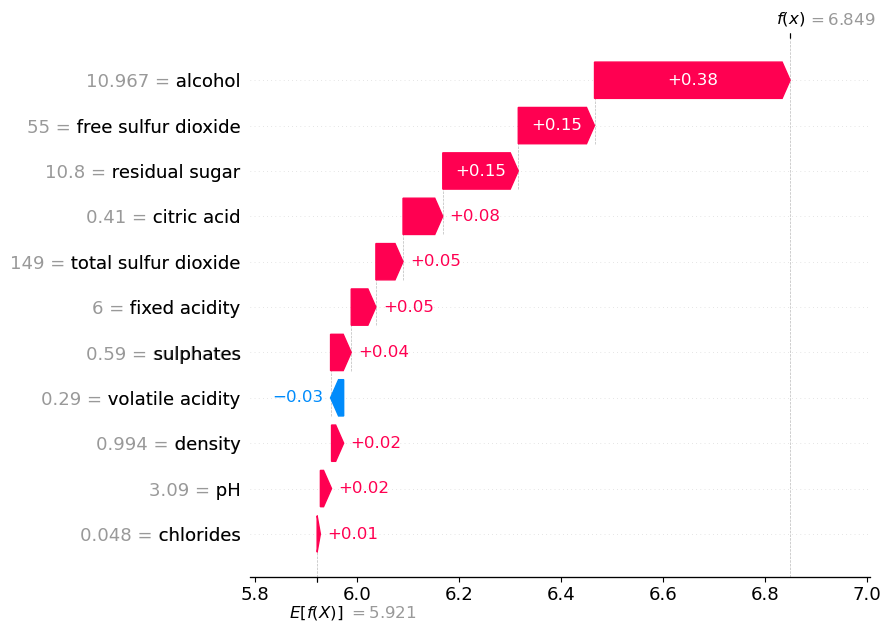

In [11]:
shap.plots.waterfall(shap_values[0], max_display=11)

### Global Model Interpretation

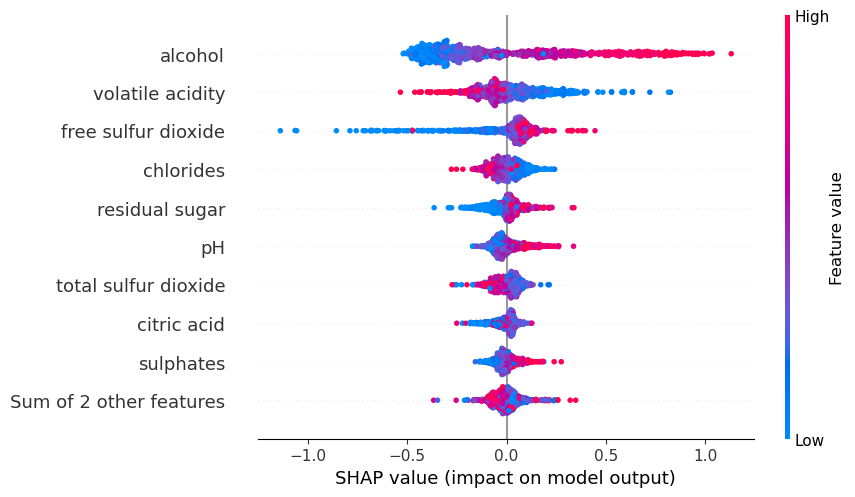

In [12]:
# Checking Feature Influence on Model's Prediction
shap.plots.beeswarm(shap_values)

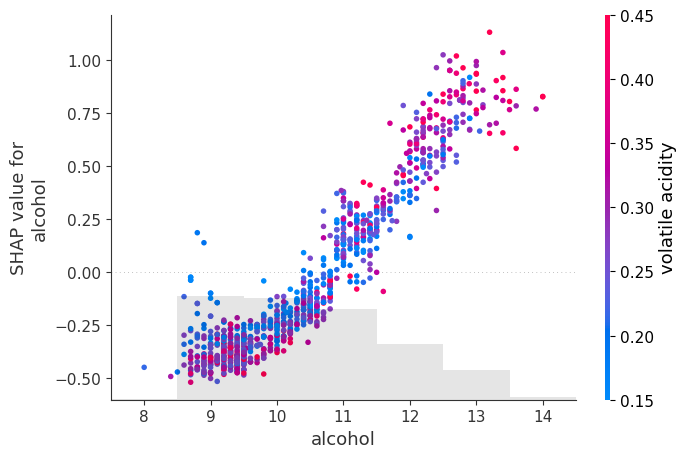

In [13]:
# Global Plotting Interaction
shap.plots.scatter(shap_values[:, "alcohol"], color=shap_values)

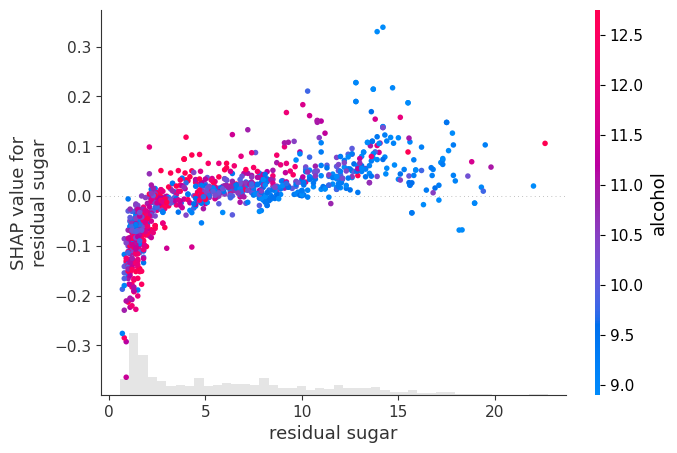

In [14]:
# Checking Dependence
shap.plots.scatter(
    shap_values[:, "residual sugar"], color=shap_values
)

### Analyzing Correlated Features

#### Correlation Matrix

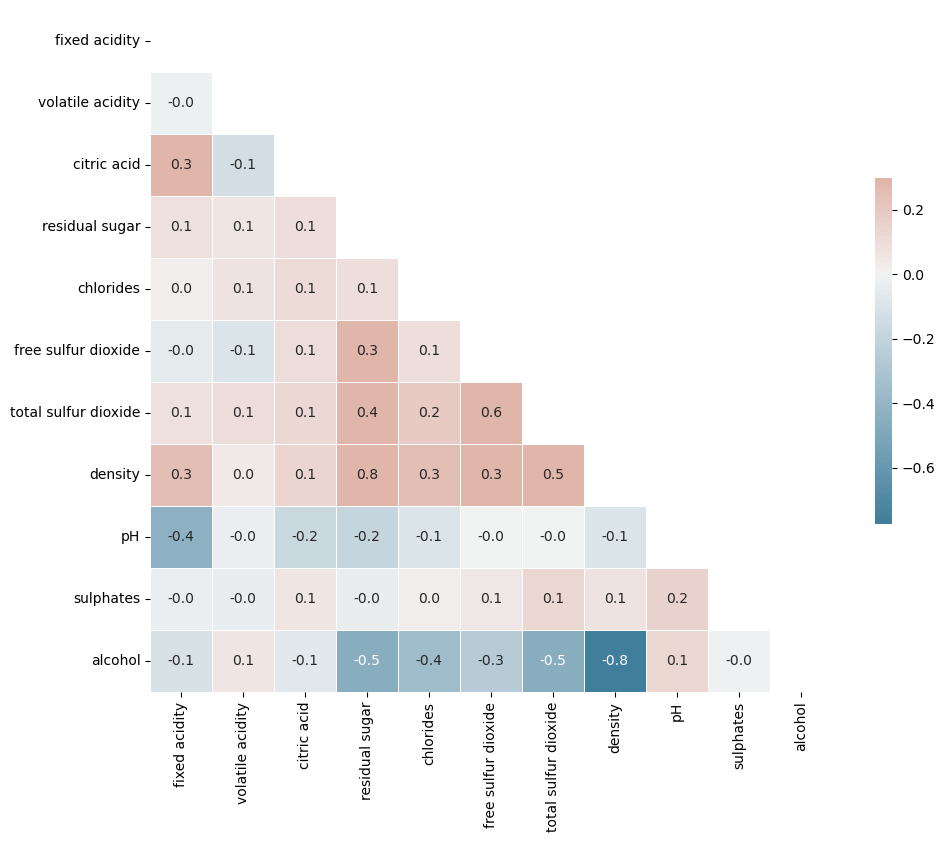

In [15]:
# Correlation Matrix
corr = X_train.corr()

# Upper Triangle Mask
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set Up
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},
            annot=True, fmt=".1f")

plt.show()

#### Tree-Base Hierarchical Clustering: Absolute Correlation

In [16]:
correlation_matrix = X_train.corr()
correlation_matrix = np.corrcoef(correlation_matrix)
correlation_matrix = np.abs(correlation_matrix)
dist_matrix = 1 - correlation_matrix

In [17]:
clustering = sch.linkage(dist_matrix, method="complete")

/var/folders/m3/3_zd43kn4nn3q52cpx_b38g00000gn/T/ipykernel_6629/1114471959.py:1: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clustering = sch.linkage(dist_matrix, method="complete")


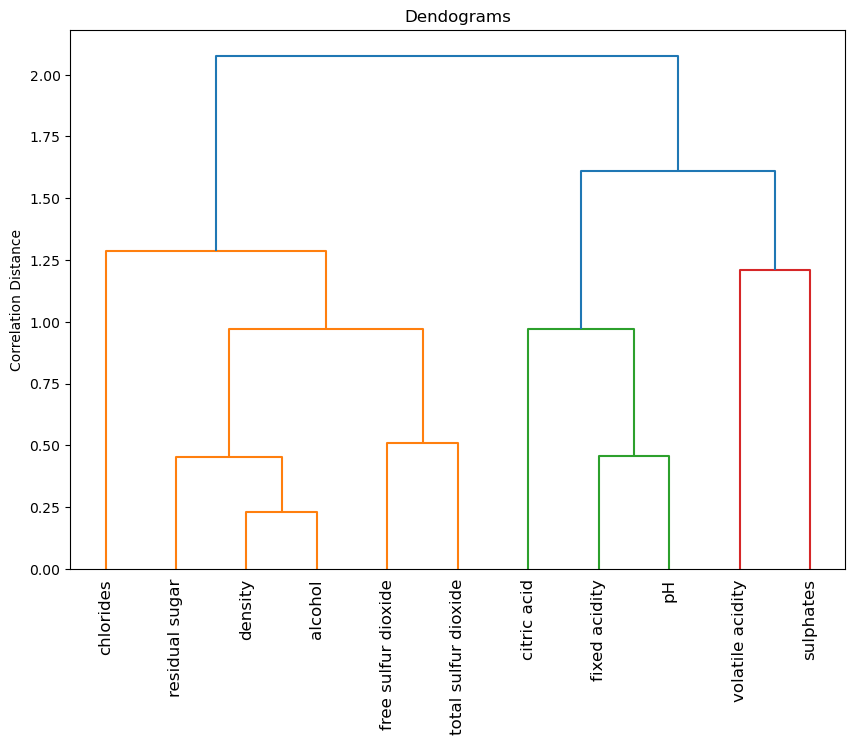

In [18]:
plt.figure(figsize=(10, 7))
plt.title("Dendograms")

dend = hierarchy.dendrogram(clustering, labels=X_train.columns)

plt.xticks(rotation=90)
plt.tick_params(axis='x', which='major', labelsize=12)
plt.ylabel('Correlation Distance')
plt.show()

In [19]:
masker = shap.maskers.Partition(X_train, clustering=clustering)

explainer2 = shap.PartitionExplainer(model.predict, masker)

shap_values2 = explainer(X_test)

 96%|=================== | 942/980 [00:14<00:00]       

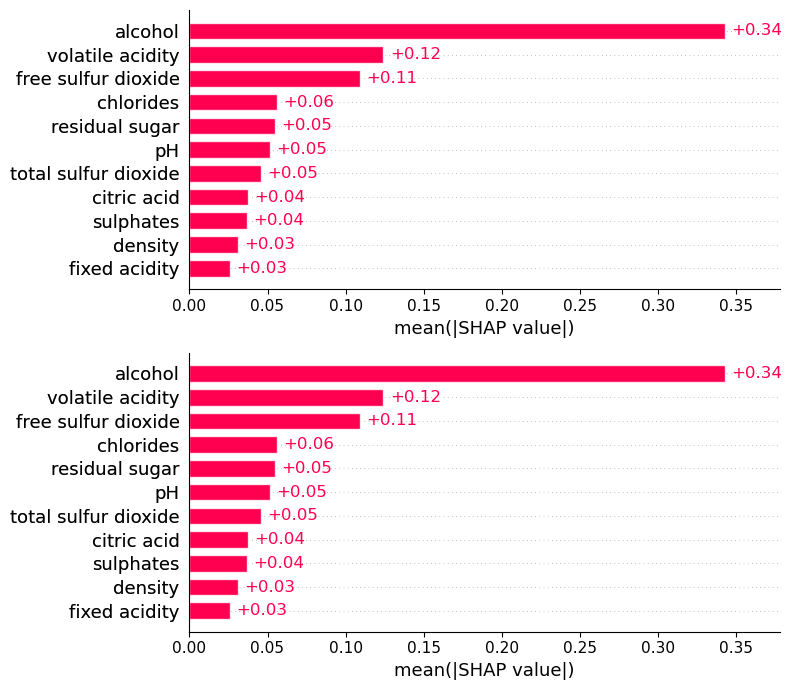

In [20]:
# Checking on SHAP Importances, as follows:
fig = plt.figure(figsize=(6, 12))
ax0 = fig.add_subplot(211)
shap.plots.bar(shap_values, max_display=11, show=False)
ax1 = fig.add_subplot(212)

shap.plots.bar(
    shap_values2, max_display=11, show=False, clustering_cutoff=0.6
)

plt.tight_layout()
plt.show()

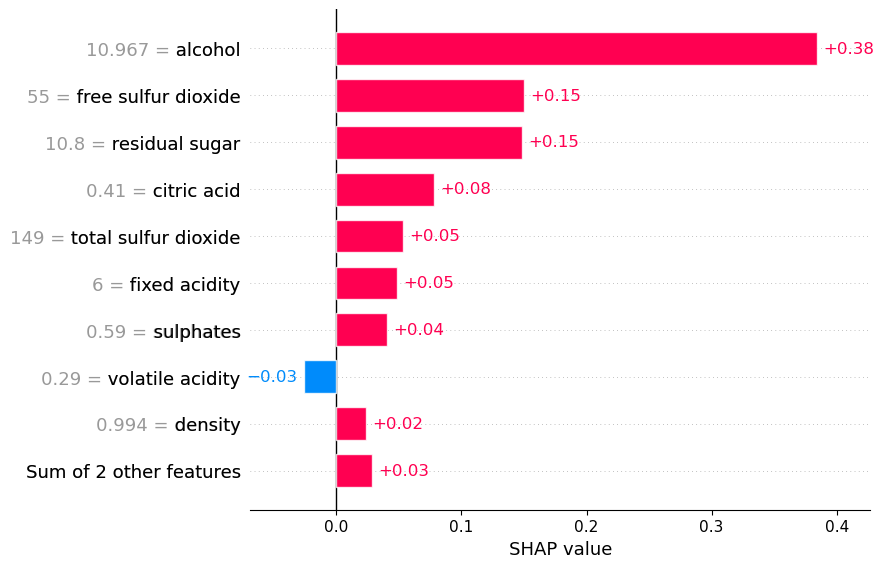

In [21]:
# Contrasting 1st Data Instance, as follows:
shap.plots.bar(shap_values2[0], clustering_cutoff=0.6)

### Understanding Model for Data Subsets

In [22]:
# Data Subsets
ind_test = np.where(X_test['alcohol'].values > 12)
ind_train = np.where(X_train['alcohol'].values > 12)

X_train_sub = X_train.iloc[ind_train]
X_test_sub = X_test.iloc[ind_test]

# Backgroud Data Based on Subset
explainer_sub = shap.Explainer(model, X_train_sub)
shap_values_sub = explainer_sub(X_test_sub)

# Backgroud Data with All Wines Included
shap_values_sub_all = shap_values[ind_test]

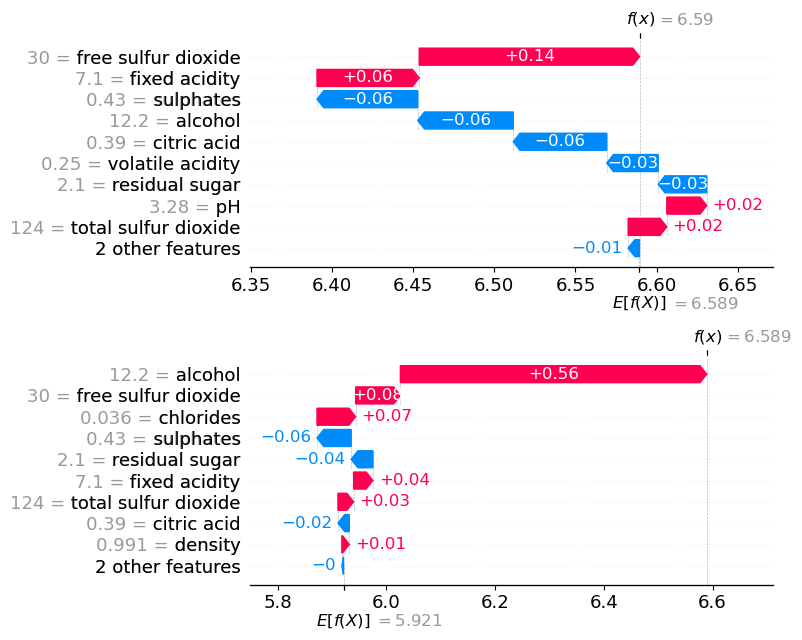

In [24]:
# Plotting Out
fig = plt.figure(figsize=(6, 12))
ax0 = fig.add_subplot(211)
shap.plots.waterfall(shap_values_sub[1], show=False)
ax1 = fig.add_subplot(212)
shap.plots.waterfall(shap_values_sub_all[1], show=False)
plt.tight_layout()
plt.show()

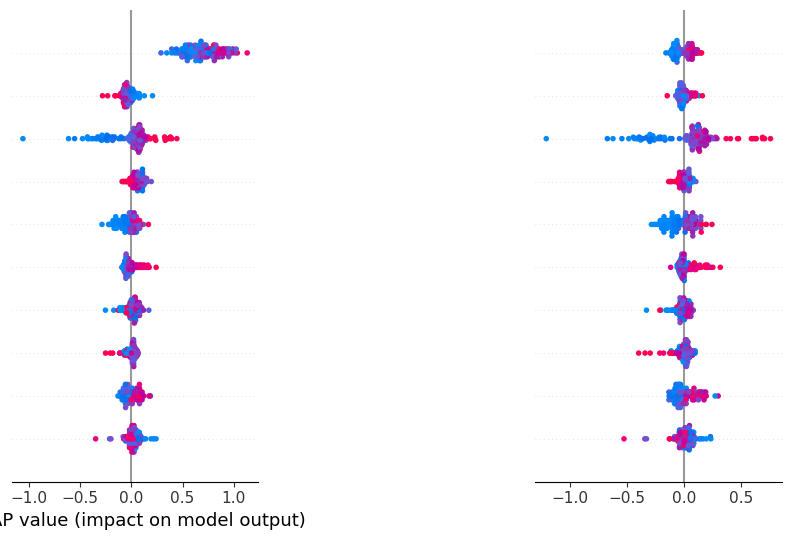

In [25]:
# Global Interpretation
ordered = np.argsort(abs(shap_values.values).mean(axis=0))[::-1]
plt.subplot(131)

shap.plots.beeswarm(
    shap_values_sub_all, show=False, color_bar=False, order=ordered
)
plt.gca().set_yticklabels([])
plt.ylabel("")
plt.subplot(133)

shap.plots.beeswarm(
    shap_values_sub, show=False, color_bar=False, order=ordered
)
plt.gca().set_yticklabels([])
plt.ylabel("")
plt.xlabel("")
plt.tight_layout()
plt.show()